# 8강 파이토치 분류 모델 구현
## 이번 강의에서 다룰 내용
1. 분류 문제 종류: 어떠한 분류 문제가 있는지 알아본다.
2. 분류 신경망 구조 : 신경망의 모양은 회귀와 같다고 볼 수 있지만, 출력층, 최적화함수, 손실함수가 다르다.
3. 이진 분류 모델 구축 : 데이터 준비, 데이터를 텐서로 변환, 모델 구축, 모델 학습, 예측 및 모델 평가하기
4. 모델 개선하기: 학습 모델이 좋지 않은 것을 확인하고 어떻게 개선할지 고민해본다.
5. 다중 클래스 분류 모델 구축 : 이진 분류 모델보다 복잡한 다중 클래스 분류 모델의 구축 예시 살펴보자.
6. 학습 시 사용할 수 있는 테크닉: 일반화 성능을 보장하는 모델 학습에 유용한 테크닉을 소개한다.

##1. 분류 문제 종류

분류 문제는 3가지로 구분할 수 있다.
* 1. 이진 분류
* 2. 다중 클래스 분류
* 3. 다중 레이블 분류
![img](https://www.researchgate.net/profile/Tansel-Doekeroglu/publication/342378595/figure/fig1/AS:905465961652224@1592891316276/a-Binary-classification-b-Multi-class-classification-c-Multi-Label-classification.ppm)

##2. 분류 신경망 구조
```
입력층: 입력 받은 데이터의 크기를 알고 그에 맞게 사이즈 조절(input_size)
은닉층 : 변형하고 싶은 크기 지정하여 입출력 세팅
은닉층 활성화(Activation): Relu /
출력층 (output_size) #예측 해야할 클래스 수
출력 활성화(Activation) : 이진 분류: `torch.sigmoid`, 다중 분류: `torch.softmax`
손실 함수 : 이진 분류: `torch.nn.BCELoss`, 다중 분류: `torch.nn.CrossEntropyLoss
최적화 함수: `torch.optim.SGD`, `torch.optim.Adam`

```


##3. 이진 분류 모델 구축 
### 분류용 데이터 만들기

In [1]:
from sklearn.datasets import make_circles


# 1000개의 샘플 
n_samples = 1000

#  Circle 데이터셋 생성
X, y = make_circles(n_samples,
                    noise=0.03, # 값에 노이즈 추가
                    random_state=42) # 재현성 보장을 위한 랜덤 시드 고정

In [2]:
print(X[:10])
print(y[:10])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]
 [-0.47964637  0.67643477]
 [-0.01364836  0.80334872]
 [ 0.77151327  0.14775959]
 [-0.16932234 -0.79345575]
 [-0.1214858   1.02150905]]
[1 1 1 1 0 1 1 1 1 0]


In [3]:
# 생성한 데이터를 데이터 프레임으로
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [4]:
# 레이블별 데이터 수 확인하기
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

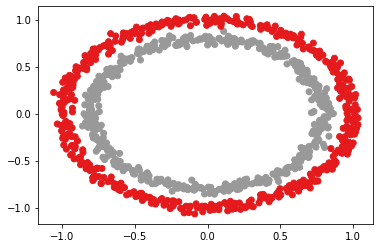

In [5]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.Set1);

### 데이터 분할하기

In [6]:
# 훈련, 테스트 데이터 분할
from sklearn.model_selection import train_test_split

train_val, test = train_test_split(circles, test_size=0.1, random_state=42)
train, val = train_test_split(train_val, test_size=0.1/0.9, random_state=42)

datasets = {
    "train": train,
    "val": val,
    "test": test
}
datasets

{'test':            X1        X2  label
 521 -0.375193  0.682660      1
 737  0.015380  0.960026      0
 740 -0.702784 -0.314717      1
 660 -0.285250  0.966378      0
 411  0.402417 -0.743754      1
 ..        ...       ...    ...
 436 -0.682198  0.765028      0
 764  0.137280  0.737127      1
 88  -0.838085 -0.027128      1
 63  -0.905510  0.498838      0
 826  0.148664 -0.795573      1
 
 [100 rows x 3 columns], 'train':            X1        X2  label
 750  0.031913  0.785291      1
 960  0.954660 -0.332228      0
 759  1.004836 -0.058785      0
 881  0.955978 -0.137028      0
 106  0.612205  0.509429      1
 ..        ...       ...    ...
 165 -0.383562  0.698672      1
 169 -0.748444 -0.670130      0
 474 -0.404276 -0.891172      0
 434 -0.895065 -0.290665      0
 695 -1.008616 -0.124031      0
 
 [800 rows x 3 columns], 'val':            X1        X2  label
 361  0.430917  0.712274      1
 91   0.802265 -0.561765      0
 311  0.742811  0.265989      1
 253  0.184497 -0.745433    

In [7]:
len(datasets["train"]),len(datasets["val"]), len(datasets["test"])

(800, 100, 100)

### 커스텀 데이터세트 만들기

In [8]:
from torch.utils.data import Dataset
class MyCirleDataset(Dataset):
  def __init__(self, df):
    self.x = list(df.iloc[:,0:2].values)
    self.y = list(df.iloc[:,2].values)

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    return torch.tensor(self.x[index]).float(), torch.tensor(self.y[index]).float()

circledata = {
    "train": MyCirleDataset(datasets["train"]),
    "val": MyCirleDataset(datasets["val"]),
    "test": MyCirleDataset(datasets["test"])
}

In [9]:
from torch.utils.data import DataLoader
import torch
dataloaders = {
    "train": DataLoader(circledata["train"], batch_size=32, shuffle=True),
    "val": DataLoader(circledata["val"], batch_size=32, shuffle=False),
    "test": DataLoader(circledata["test"], batch_size=32, shuffle=False)
}

dataloaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7f20bd6e9590>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7f20bd6e92d0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f20bd6e9ed0>}

In [10]:
for data in dataloaders["train"]:
    x, y = data
    print(x.shape, y.shape)

torch.Size([32, 2]) torch.Size([32])
torch.Size([32, 2]) torch.Size([32])
torch.Size([32, 2]) torch.Size([32])
torch.Size([32, 2]) torch.Size([32])
torch.Size([32, 2]) torch.Size([32])
torch.Size([32, 2]) torch.Size([32])
torch.Size([32, 2]) torch.Size([32])
torch.Size([32, 2]) torch.Size([32])
torch.Size([32, 2]) torch.Size([32])
torch.Size([32, 2]) torch.Size([32])
torch.Size([32, 2]) torch.Size([32])
torch.Size([32, 2]) torch.Size([32])
torch.Size([32, 2]) torch.Size([32])
torch.Size([32, 2]) torch.Size([32])
torch.Size([32, 2]) torch.Size([32])
torch.Size([32, 2]) torch.Size([32])
torch.Size([32, 2]) torch.Size([32])
torch.Size([32, 2]) torch.Size([32])
torch.Size([32, 2]) torch.Size([32])
torch.Size([32, 2]) torch.Size([32])
torch.Size([32, 2]) torch.Size([32])
torch.Size([32, 2]) torch.Size([32])
torch.Size([32, 2]) torch.Size([32])
torch.Size([32, 2]) torch.Size([32])
torch.Size([32, 2]) torch.Size([32])


### 모델 만들기

In [11]:
import torch
from torch import nn

# cpu나 gpu에서 모두 동작하게 만들기
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [12]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=5)
        self.linear2 = nn.Linear(in_features=5, out_features=1) 
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.linear2(out)
        return out

model = MLP()
model.to(device)

MLP(
  (linear1): Linear(in_features=2, out_features=5, bias=True)
  (linear2): Linear(in_features=5, out_features=1, bias=True)
)

우리가 만든 모델을 시각적으로 파악해봅시다.
https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=5,1&seed=0.04242&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false

### 손실 및 최적화 함수 설정

시그모이드 함수가 이진 분류에 필요한 이유

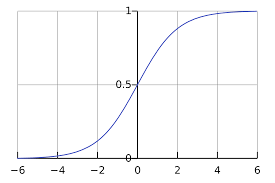

In [13]:
import torch.optim as optim

loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss는 sigmoid를 내장하고 있음

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.1)

# 모델 평가를 위한 지표를 만들어 봅시다.
def acc_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() 두개의 텐서가 같은지 평가해줌
    acc = (correct / len(y_pred)) * 100 
    return acc

### 모델 학습하기

In [14]:
torch.manual_seed(42)

# 전체 학습 데이터로 몇번 학습 시킬 것이냐를 결정
epochs = 101

# 손실 값을 저장하기 위한 변수 정의
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0.0

    for i, data in enumerate(dataloaders["train"]):
        x, y = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = model(x)
        train_loss = loss_fn(outputs, y.view(-1, 1))
        train_acc = acc_fn(torch.round(torch.sigmoid(outputs)), y.view(-1,1))
        train_loss.backward()
        optimizer.step()
        
        epoch_train_loss += train_loss.item()
        
    model.eval()
    epoch_val_loss = 0.0
    with torch.inference_mode():
        for i, data in enumerate(dataloaders["test"]):
            x, y = data[0].to(device), data[1].to(device)
                        
            outputs = model(x)
            val_loss = loss_fn(outputs, y.view(-1, 1))
            val_acc = acc_fn(torch.round(torch.sigmoid(outputs)), y.view(-1,1))
            epoch_val_loss += val_loss.item()
            
    epoch_train_loss /= len(dataloaders["train"])
    epoch_val_loss /= len(dataloaders["test"])
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    if epoch % 10 == 0:
        print("[Epoch %d] Train Loss: %.3f  Train acc : %.3f Validation Loss: %.3f Validation acc : %.3f" %
              (epoch, epoch_train_loss, train_acc, epoch_val_loss, val_acc))

[Epoch 0] Train Loss: 0.700  Train acc : 50.000 Validation Loss: 0.718 Validation acc : 25.000
[Epoch 10] Train Loss: 0.696  Train acc : 50.000 Validation Loss: 0.693 Validation acc : 25.000
[Epoch 20] Train Loss: 0.703  Train acc : 53.125 Validation Loss: 0.681 Validation acc : 75.000
[Epoch 30] Train Loss: 0.701  Train acc : 43.750 Validation Loss: 0.687 Validation acc : 75.000
[Epoch 40] Train Loss: 0.699  Train acc : 50.000 Validation Loss: 0.692 Validation acc : 50.000
[Epoch 50] Train Loss: 0.696  Train acc : 46.875 Validation Loss: 0.707 Validation acc : 25.000
[Epoch 60] Train Loss: 0.701  Train acc : 46.875 Validation Loss: 0.682 Validation acc : 75.000
[Epoch 70] Train Loss: 0.694  Train acc : 56.250 Validation Loss: 0.703 Validation acc : 25.000
[Epoch 80] Train Loss: 0.696  Train acc : 43.750 Validation Loss: 0.697 Validation acc : 25.000
[Epoch 90] Train Loss: 0.700  Train acc : 43.750 Validation Loss: 0.695 Validation acc : 75.000
[Epoch 100] Train Loss: 0.695  Train acc 

### 결과 리포팅하기

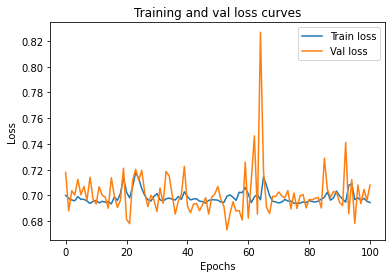

In [15]:
epoch_count = range(epochs)
plt.plot(epoch_count, train_losses, label="Train loss")
plt.plot(epoch_count, val_losses, label="Val loss")
plt.title("Training and val loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

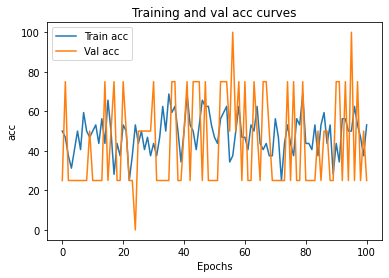

In [16]:
epoch_count = range(epochs)
plt.plot(epoch_count, train_accs, label="Train acc")
plt.plot(epoch_count, val_accs, label="Val acc")
plt.title("Training and val acc curves")
plt.ylabel("acc")
plt.xlabel("Epochs")
plt.legend();

### 훈련된 모델로 예측값 생성하기

In [17]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

In [18]:
train_X=torch.tensor(datasets["train"].iloc[:,0:2].values).float()
train_y=torch.tensor(datasets["train"].iloc[:,2].values).float()
test_X=torch.tensor(datasets["test"].iloc[:,0:2].values).float()
test_y=torch.tensor(datasets["test"].iloc[:,2].values).float()

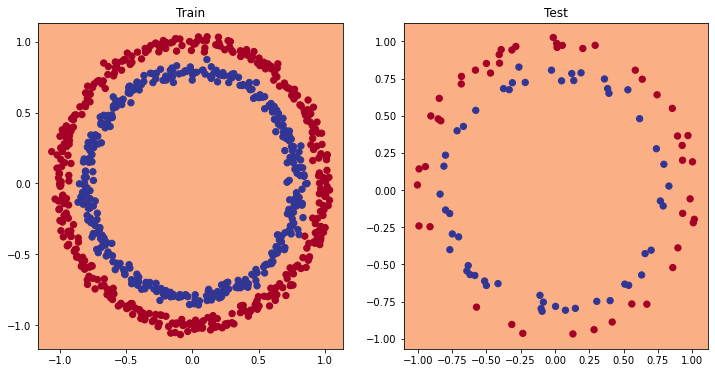

In [19]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, train_X, train_y)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, test_X, test_y)

##4. 모델 개선하기
모델 개선 기법
* 더 많은 레이어 추가
* 더 많은 히든 유닛 추가
* 더 많은 반복 수
* 활성화 함수 변경
* 학습률 변경
* 손실 함수 변경
* 전이 학습 사용

In [20]:
class MLP2(nn.Module):
    def __init__(self):
        super(MLP2, self).__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=10) #히든 유닛 수 늘리기
        self.linear2 = nn.Linear(in_features=10, out_features=10)
        self.linear3 = nn.Linear(in_features=10, out_features=1) #레이어 추가
        self.relu = nn.ReLU() #활성화 함수 사용
    
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.linear3(out)
        return out

model2 = MLP2()
model2.to(device)

MLP2(
  (linear1): Linear(in_features=2, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [21]:
import torch.optim as optim

loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss는 sigmoid를 내장하고 있음

optimizer = torch.optim.SGD(params=model2.parameters(), lr=0.01)

# 모델 평가를 위한 지표를 만들어 봅시다.

def acc_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() 두개의 텐서가 같은지 평가해줌
    acc = (correct / len(y_pred)) * 100 
    return acc

In [22]:
torch.manual_seed(42)

# 전체 학습 데이터로 몇번 학습 시킬 것이냐를 결정
epochs = 1000 #반복횟수 늘리기

# 손실 값을 저장하기 위한 변수 정의
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    model2.train()
    epoch_train_loss = 0.0

    for i, data in enumerate(dataloaders["train"]):
        x, y = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = model2(x)
        train_loss = loss_fn(outputs, y.view(-1, 1))
        train_acc = acc_fn(torch.round(torch.sigmoid(outputs)), y.view(-1,1))
        train_loss.backward()
        optimizer.step()
        
        epoch_train_loss += train_loss.item()
        
    model2.eval()
    epoch_val_loss = 0.0
    with torch.inference_mode():
        for i, data in enumerate(dataloaders["test"]):
            x, y = data[0].to(device), data[1].to(device)
                        
            outputs = model2(x)
            val_loss = loss_fn(outputs, y.view(-1, 1))
            val_acc = acc_fn(torch.round(torch.sigmoid(outputs)), y.view(-1,1))
            epoch_val_loss += val_loss.item()
            
    epoch_train_loss /= len(dataloaders["train"])
    epoch_val_loss /= len(dataloaders["test"])
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    if epoch % 100 == 0:
        print("[Epoch %d] Train Loss: %.3f  Train acc : %.3f Validation Loss: %.3f Validation acc : %.3f" %
              (epoch, epoch_train_loss, train_acc, epoch_val_loss, val_acc))

[Epoch 0] Train Loss: 0.693  Train acc : 43.750 Validation Loss: 0.688 Validation acc : 75.000
[Epoch 100] Train Loss: 0.683  Train acc : 53.125 Validation Loss: 0.688 Validation acc : 50.000
[Epoch 200] Train Loss: 0.664  Train acc : 75.000 Validation Loss: 0.680 Validation acc : 50.000
[Epoch 300] Train Loss: 0.601  Train acc : 75.000 Validation Loss: 0.630 Validation acc : 75.000
[Epoch 400] Train Loss: 0.353  Train acc : 93.750 Validation Loss: 0.373 Validation acc : 100.000
[Epoch 500] Train Loss: 0.126  Train acc : 100.000 Validation Loss: 0.148 Validation acc : 100.000
[Epoch 600] Train Loss: 0.050  Train acc : 100.000 Validation Loss: 0.070 Validation acc : 100.000
[Epoch 700] Train Loss: 0.029  Train acc : 100.000 Validation Loss: 0.046 Validation acc : 100.000
[Epoch 800] Train Loss: 0.020  Train acc : 100.000 Validation Loss: 0.038 Validation acc : 100.000
[Epoch 900] Train Loss: 0.015  Train acc : 100.000 Validation Loss: 0.029 Validation acc : 100.000


### 테스트 데이터로 결과 확인해보기

In [23]:
train_X=torch.tensor(datasets["train"].iloc[:,0:2].values).float()
train_y=torch.tensor(datasets["train"].iloc[:,2].values).float()
test_X=torch.tensor(datasets["test"].iloc[:,0:2].values).float()
test_y=torch.tensor(datasets["test"].iloc[:,2].values).float()

In [24]:
# 예측 생성
model2.eval()
with torch.inference_mode():
    y_preds = (torch.round(torch.sigmoid(model2(test_X).squeeze())))
y_preds[:10], test_y[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

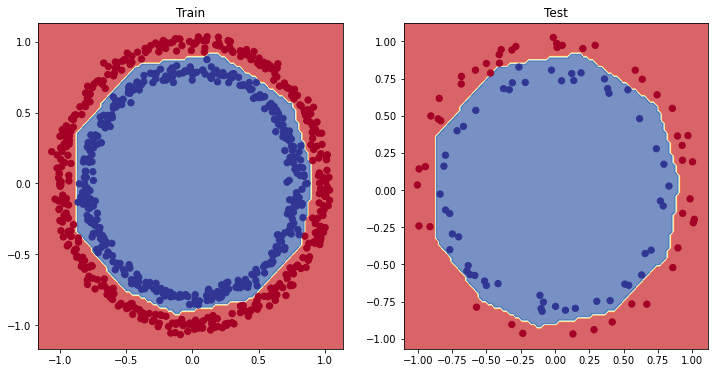

In [25]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model2, train_X, train_y)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model2, test_X, test_y)

##5. 다중 클래스 분류 모델 구축
### 데이터 만들기

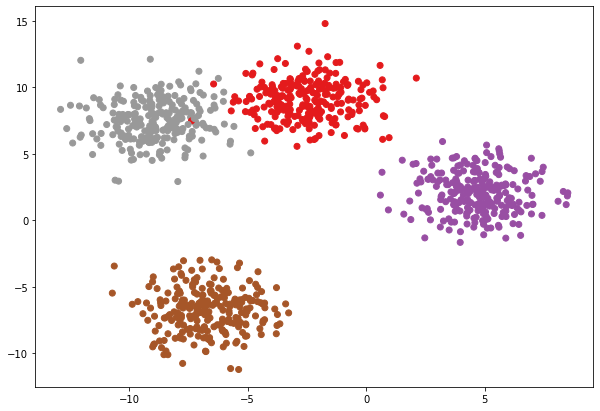

In [26]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2

X, y = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # 특성 수
    centers=NUM_CLASSES, # 클래스 숫자 
    cluster_std=1.5, #약간 섞어줌
    random_state=42
)
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1);

### 데이터 분할하기

In [27]:
# 생성한 데이터를 데이터 프레임으로
import pandas as pd
blob = pd.DataFrame({"X1":X[:, 0],
                     "X2": X[:, 1],
                     "label":y
})
blob.head(10)

,X1,X2,label
0,-8.413396,6.935165,3
1,-5.766484,-6.431171,2
2,-6.042137,-6.766102,2
3,3.950837,0.698403,1
4,4.250492,-0.281545,1
5,-6.794108,-6.477221,2
6,5.210176,2.889048,1
7,-5.505136,-6.360377,2
8,-6.543756,-4.833899,2
9,6.449642,0.747766,1


In [28]:
# 훈련, 테스트 데이터 분할
from sklearn.model_selection import train_test_split

train_val, test = train_test_split(blob, test_size=0.1, random_state=42)
train, val = train_test_split(train_val, test_size=0.1/0.9, random_state=42)

datasets = {
    "train": train,
    "val": val,
    "test": test
}
datasets

{'test':            X1         X2  label
 521  4.667506   4.487826      1
 737 -7.996949   6.880302      3
 740 -6.280095  -7.857145      2
 660  3.683269   1.176674      1
 411 -0.140378  10.165438      0
 ..        ...        ...    ...
 436 -8.867457   6.868753      3
 764  5.299901   1.220088      1
 88  -2.888050   7.142611      0
 63  -7.854477   7.615627      3
 826 -7.142067  -8.013727      2
 
 [100 rows x 3 columns], 'train':             X1        X2  label
 750   5.890762  2.661940      1
 960   4.359571  1.313573      1
 759  -6.189669 -7.896683      2
 881  -8.957790  8.002081      3
 106   6.770635  1.117050      1
 ..         ...       ...    ...
 165  -4.296153  9.999117      0
 169  -5.079006 -7.865451      2
 474 -10.337281  6.566361      3
 434  -7.408623  7.754209      3
 695  -8.524040 -9.040186      2
 
 [800 rows x 3 columns], 'val':            X1        X2  label
 361 -4.664817 -4.809973      2
 91  -0.347288  6.860493      0
 311 -6.599295  6.916838      3
 253

### 커스텀 데이터 세트 만들기

In [29]:
len(datasets["train"]),len(datasets["val"]), len(datasets["test"])

(800, 100, 100)

In [43]:
from torch.utils.data import Dataset
class MyblobDataset(Dataset):
  def __init__(self, df):
    self.x = list(df.iloc[:,0:2].values)
    self.y = list(df.iloc[:,2].values)

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    return torch.tensor(self.x[index]).float(), torch.tensor(self.y[index]).long()

blobdata = {
    "train": MyblobDataset(datasets["train"]),
    "val": MyblobDataset(datasets["val"]),
    "test": MyblobDataset(datasets["test"])
}

In [44]:
blobdata["train"][0:11]

(tensor([[  5.8908,   2.6619],
         [  4.3596,   1.3136],
         [ -6.1897,  -7.8967],
         [ -8.9578,   8.0021],
         [  6.7706,   1.1171],
         [ -2.6723,   9.6169],
         [-10.6069,   9.1050],
         [ -7.0121,  -3.0105],
         [ -3.7667,  -7.9139],
         [ -4.6070,   9.8587],
         [ -7.1390,  -4.3125]]), tensor([1, 1, 2, 3, 1, 0, 3, 2, 2, 0, 2]))

In [45]:
from torch.utils.data import DataLoader

blob_dataloaders = {
    "train": DataLoader(blobdata["train"], batch_size=32, shuffle=True),
    "val": DataLoader(blobdata["val"], batch_size=32, shuffle=False),
    "test": DataLoader(blobdata["test"], batch_size=32, shuffle=False)
}

blob_dataloaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7f204b99e950>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7f204b997090>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f204b99e110>}

In [46]:
for data in blob_dataloaders["train"]:
    x, y = data
    print(x.shape, x.dtype, y.shape, y.dtype)

torch.Size([32, 2]) torch.float32 torch.Size([32]) torch.int64
torch.Size([32, 2]) torch.float32 torch.Size([32]) torch.int64
torch.Size([32, 2]) torch.float32 torch.Size([32]) torch.int64
torch.Size([32, 2]) torch.float32 torch.Size([32]) torch.int64
torch.Size([32, 2]) torch.float32 torch.Size([32]) torch.int64
torch.Size([32, 2]) torch.float32 torch.Size([32]) torch.int64
torch.Size([32, 2]) torch.float32 torch.Size([32]) torch.int64
torch.Size([32, 2]) torch.float32 torch.Size([32]) torch.int64
torch.Size([32, 2]) torch.float32 torch.Size([32]) torch.int64
torch.Size([32, 2]) torch.float32 torch.Size([32]) torch.int64
torch.Size([32, 2]) torch.float32 torch.Size([32]) torch.int64
torch.Size([32, 2]) torch.float32 torch.Size([32]) torch.int64
torch.Size([32, 2]) torch.float32 torch.Size([32]) torch.int64
torch.Size([32, 2]) torch.float32 torch.Size([32]) torch.int64
torch.Size([32, 2]) torch.float32 torch.Size([32]) torch.int64
torch.Size([32, 2]) torch.float32 torch.Size([32]) torc

### 모델 만들기

In [47]:
import torch
from torch import nn

# cpu나 gpu에서 모두 동작하게 만들기
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [48]:
class blob_MLP(nn.Module):
    def __init__(self):
        super(blob_MLP, self).__init__()
        self.linear1 = nn.Linear(in_features=NUM_FEATURES, out_features=10) #히든 유닛 수 늘리기
        self.linear2 = nn.Linear(in_features=10, out_features=10)
        self.linear3 = nn.Linear(in_features=10, out_features=NUM_CLASSES) #클래스 수로 설정
        self.relu = nn.ReLU() #활성화 함수 사용
    
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.linear3(out)
        return out

model3 = blob_MLP()
model3.to(device)

blob_MLP(
  (linear1): Linear(in_features=2, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=4, bias=True)
  (relu): ReLU()
)

### 손실 및 최적화 함수 설정

In [49]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model3.parameters(), lr=0.1)

# 모델 평가를 위한 지표를 만들어 봅시다.

def acc_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() 두개의 텐서가 같은지 평가해줌
    acc = (correct / len(y_pred)) * 100 
    return acc

### 모델 학습하기

In [55]:
torch.manual_seed(42)

# 전체 학습 데이터로 몇번 학습 시킬 것이냐를 결정
epochs = 200 #반복횟수 늘리기

# 손실 값을 저장하기 위한 변수 정의
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    model3.train()
    epoch_train_loss = 0.0

    for i, data in enumerate(blob_dataloaders["train"]):
        x, y = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model3(x)
        train_loss = loss_fn(outputs, y)
        
        train_acc = acc_fn(torch.softmax(outputs, dim=1).argmax(dim=1), y)
        train_loss.backward()
        optimizer.step()
        
        epoch_train_loss += train_loss.item()
        
    model2.eval()
    epoch_val_loss = 0.0
    with torch.inference_mode():
        for i, data in enumerate(blob_dataloaders["test"]):
            x, y = data[0].to(device), data[1].to(device)
                        
            outputs = model3(x)
            val_loss = loss_fn(outputs, y)
            val_acc = acc_fn(torch.softmax(outputs, dim=1).argmax(dim=1), y)
            epoch_val_loss += val_loss.item()
            
    epoch_train_loss /= len(dataloaders["train"])
    epoch_val_loss /= len(dataloaders["test"])
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    if epoch % 10 == 0:
        print("[Epoch %d] Train Loss: %.3f  Train acc : %.3f Validation Loss: %.3f Validation acc : %.3f" %
              (epoch, epoch_train_loss, train_acc, epoch_val_loss, val_acc))

[Epoch 0] Train Loss: 0.014  Train acc : 100.000 Validation Loss: 0.004 Validation acc : 100.000
[Epoch 10] Train Loss: 0.013  Train acc : 100.000 Validation Loss: 0.002 Validation acc : 100.000
[Epoch 20] Train Loss: 0.014  Train acc : 100.000 Validation Loss: 0.002 Validation acc : 100.000
[Epoch 30] Train Loss: 0.014  Train acc : 100.000 Validation Loss: 0.003 Validation acc : 100.000
[Epoch 40] Train Loss: 0.016  Train acc : 100.000 Validation Loss: 0.003 Validation acc : 100.000
[Epoch 50] Train Loss: 0.016  Train acc : 93.750 Validation Loss: 0.004 Validation acc : 100.000
[Epoch 60] Train Loss: 0.013  Train acc : 100.000 Validation Loss: 0.003 Validation acc : 100.000
[Epoch 70] Train Loss: 0.015  Train acc : 100.000 Validation Loss: 0.004 Validation acc : 100.000
[Epoch 80] Train Loss: 0.014  Train acc : 100.000 Validation Loss: 0.002 Validation acc : 100.000
[Epoch 90] Train Loss: 0.015  Train acc : 100.000 Validation Loss: 0.004 Validation acc : 100.000
[Epoch 100] Train Loss

### 결과 리포팅하기

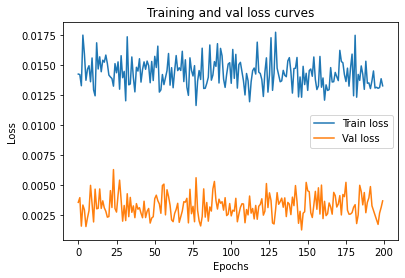

In [56]:
epoch_count = range(epochs)
plt.plot(epoch_count, train_losses, label="Train loss")
plt.plot(epoch_count, val_losses, label="Val loss")
plt.title("Training and val loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

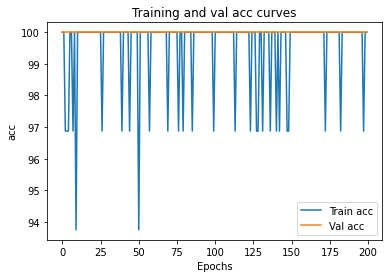

In [57]:
epoch_count = range(epochs)
plt.plot(epoch_count, train_accs, label="Train acc")
plt.plot(epoch_count, val_accs, label="Val acc")
plt.title("Training and val acc curves")
plt.ylabel("acc")
plt.xlabel("Epochs")
plt.legend();

### 훈련된 모델로 예측값 생성하기

In [58]:
train_X=torch.tensor(datasets["train"].iloc[:,0:2].values).float()
train_y=torch.tensor(datasets["train"].iloc[:,2].values).long()
test_X=torch.tensor(datasets["test"].iloc[:,0:2].values).float()
test_y=torch.tensor(datasets["test"].iloc[:,2].values).long()

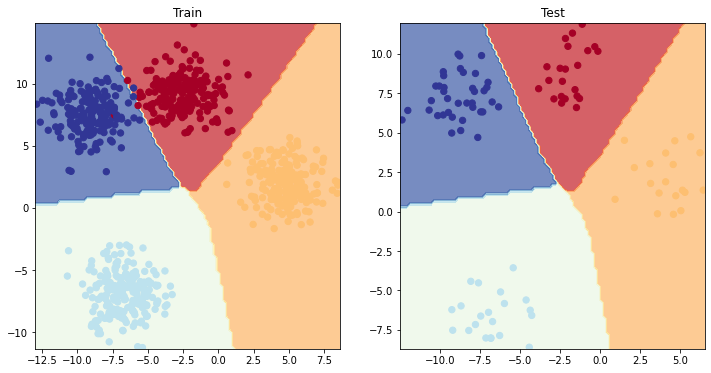

In [59]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model3, train_X, train_y)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model3, test_X, test_y)

In [60]:
!pip -q install torchmetrics

     |████████████████████████████████| 419 kB 14.6 MB/s 


In [62]:
from torchmetrics import Accuracy
outputs=model3(test_X)
preds=torch.softmax(outputs, dim=1).argmax(dim=1)
# Setup metric and make sure it's on the target device
acc = Accuracy().to(device)

# Calculate accuracy
acc(preds, test_y)

tensor(1.)

##6. 학습 시 사용할 수 있는 테크닉
이번 실습의 모델 개선 부분에서 몇가지를 수정함으로써 모델의 성능을 개선시킬 수 있었다. 이러한 문제 상황에서 사용할 수 있는 몇 가지 테크닉, 레이어를 소개하려고 한다.

상황1. 과소적합(underfitting) 모델 학습이 덜 이루어졌다고 판단될때, (성능이 안좋은 경우)

1. 학습할 데이터의 양을 늘리기
2. 모델 복잡도 높이기(히든 레이어 추가, 유닛 크기 늘려보기)
3. 활성화 함수바꿔보기
4. 모델의 반복 학습 수를 늘리기

상황2. 과대적합(overfitting) 모델 학습이 학습 데이터에 너무 잘 되었을때,

1. 학습 데이터양을 늘리기(모델이 볼 수 있는 표본을 늘려 줌)
2. 모델 복잡도 낮추기(히든 레이어 삭제, 드롭아웃)
3. 정규화 활용하기(가중치 규제, 가중치 초기화, 배치 정규화, 층 정규화)
4. 활성화 함수 바꿔보기
5. 모델의 반복 학습의 적절한 포인트 찾기(조기 종료)

### 여러가지 활성화 함수
과거에 활성화 함수는 시그모이드만 존재하였음
레이어를 여러개 쌓으면서 비선형성을 학습할 수 있도록 활성화함수를 동시에 사용하다보니 기울기가 소실되는 문제가 있었음

![img](https://t1.daumcdn.net/cfile/tistory/996A3F365AB61ADA08)

![img](https://images.velog.io/images/yunyoseob/post/560ea4e6-ea97-4c21-bfac-d4742eeefb34/vanishinggradient-1.png)

그래서 그라디언트를 소실시키지 않는 활성화 함수에 대해 많은 연구들이 진행되었고 아래와 같이 많은 활성화 함수들이 등장했음
![img](https://miro.medium.com/max/1192/1*ACHo09NFhKvYCsOFHxWVbA.png)

### 드롭아웃
* 신경망의 일부를 사용하지 않는 방법으로 아래의 두개의 그림으로 간단하게 표현해볼 수 있다.
![img](https://wikidocs.net/images/page/60751/%EB%93%9C%EB%A1%AD%EC%95%84%EC%9B%83.PNG)


![img](https://wikidocs.net/images/page/60751/%EB%93%9C%EB%A1%AD%EC%95%84%EC%9B%832.PNG)

### 가중치 규제
L1 규제 : 가중치 들의 절대값의 합계를 비용 함수에 추가
L2 규제 : 가중치들의 제곱합을 비용 함수에 추가
규제를 사용하면 가중치들의 값이 작아지는 현상을 띔
경험적으로 L2 규제가 더 잘 동작하므로 가중치 감쇠(weight decay)라고 하고 파이토치에서 최적화함수에 간단하게 사용할 수 있다.
```
odel = Architecture1(10, 20, 2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
```

### 가중치 초기화
같은 모델을 훈련시키더라고 가중치가 초기에 어떤 값을 가졌느냐에 따라 모델의 훈련 결과가 달라짐 자세한 내용은 https://deepinsight.tistory.com/114 를 참고
1. 자비에 초기화
2. HE 초기화
```
# 레이어 정의
linear1 = torch.nn.Linear(784, 256, bias=True)
linear2 = torch.nn.Linear(256, 256, bias=True)
linear3 = torch.nn.Linear(256, 10, bias=True)
relu = torch.nn.ReLU()
```
# Xavier 초기화
```
torch.nn.init.xavier_uniform_(linear1.weight)
torch.nn.init.xavier_uniform_(linear2.weight)
torch.nn.init.xavier_uniform_(linear3.weight)
```
# HE 초기화
```
torch.nn.init.kaiming_uniform_(linear1.weight)
torch.nn.init.kaiming_uniform_(linear2.weight)
torch.nn.init.kaiming_uniform_(linear3.weight)
```


### 정규화
입력 데이터를 정규화 방법으로 배치 정규화(Batch Normalization)와 층 정규화(Layer Normalization)방법이 있다.
1. 배치 정규화: 샘플 단위로 정규화함
2. 층 정규화: 특성 단위로 정규화함
![img](https://yonghyuc.files.wordpress.com/2020/03/bn_vs_ln.png)
```
class SoftmaxClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(28*28, 32, bias=True).to(device)
        self.linear2 = nn.Linear(32, 32, bias=True).to(device)
        self.linear3 = nn.Linear(32, 10, bias=True).to(device)
        self.relu = torch.nn.ReLU()
        self.bn1 = nn.BatchNorm1d(32)
        self.bn2 = nn.BatchNorm1d(32)
        
        torch.nn.init.xavier_uniform_(self.linear1.weight)
        torch.nn.init.xavier_uniform_(self.linear2.weight)
        torch.nn.init.xavier_uniform_(self.linear3.weight)
        
        self.model = nn.Sequential(self.linear1, self.bn1, self.relu,
                                   self.linear2, self.bn2, self.relu,
                                   self.linear3).to(device)
    
    def forward(self, x):
        return self.model(x)
```


### 조기 종료
파이토치에서는 라이브러리별 조기 종료 함수를 제공하고 있으며 원리는 계속 감소해야할 손실 값을 정하고 몇번 이상 감소하지 않으면 학습을 종료하도록 하는 원리임

```
pytorch_lightning.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
```